In [1]:
# 1. Imports and Setup

import sys, os

sys.path.append(os.path.abspath(".."))
from notebook_setup import *
from src.evaluation import run_statistical_comparison
from src.visualization import plot_dm_results

tracker = ExperimentTracker()

Checking for crucial dependencies...
  -> Chronos: Available
  -> TimeGPT: Available
  -> API Key: Found
Notebook setup complete.


!!! SMOKE TEST ENABLED: Using last 2000 points !!!
Dataset: Kaggle BTC/USD Hourly
Total: 2000 | Train: 1832 | Test: 168
Train period: 2025-09-29 16:00:00 to 2025-12-14 23:00:00
Test period:  2025-12-15 00:00:00 to 2025-12-21 23:00:00
Seasonal period: 24


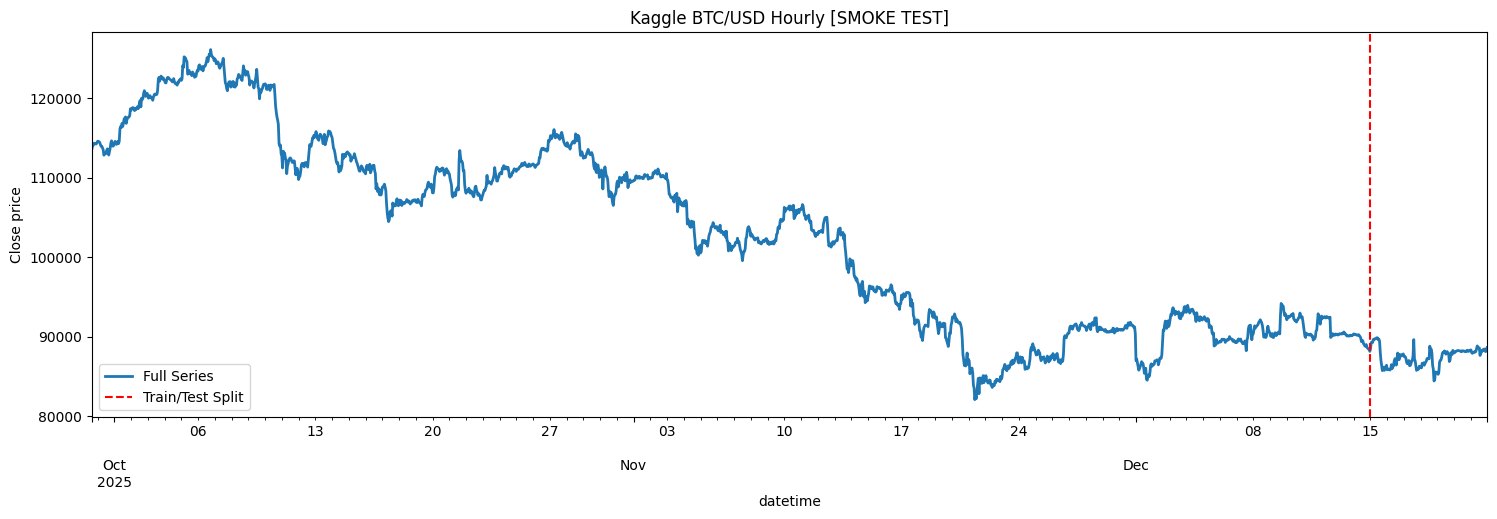

In [2]:
# 2. Data Loading and Configuration

# === DATASET CONFIGURATION ===
DATASET_CONFIG = {
    "file_path": "../datasets/kaggle_btcusd_hourly.csv",
    "time_column": "datetime",
    "target_column": "btc_usd",
    "frequency": "H",  # 'MS'=monthly start, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    "test_periods": 168,  # Number of periods to hold out for testing (168 = 7 days)
    "seasonal_period": 24,  # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    "name": "Kaggle BTC/USD Hourly",
    "cv_start_ratio": 0.9,  # Ratio to start CV splits (e.g., 0.9 = last 10% for validation) for bigger datasets
}

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])
series = TimeSeries.from_dataframe(
    df, DATASET_CONFIG["time_column"], DATASET_CONFIG["target_column"]
)
series = series.astype(np.float32)

SMOKE_TEST = True
SMOKE_TEST_POINTS = 2000

if SMOKE_TEST:
    smoke_msg = f"!!! SMOKE TEST ENABLED: Using last {SMOKE_TEST_POINTS} points !!!"
    print(smoke_msg)
    print("=" * len(smoke_msg))
    series = series[-SMOKE_TEST_POINTS:]

# === TRAIN/TEST SPLIT ===
# Test set is held out completely - models never see it during training or validation
freq = DATASET_CONFIG["frequency"]
test_periods = DATASET_CONFIG["test_periods"]
offset_map = {
    "MS": pd.DateOffset(months=test_periods),
    "QS": pd.DateOffset(months=test_periods * 3),
    "YS": pd.DateOffset(years=test_periods),
    "D": pd.DateOffset(days=test_periods),
    "H": pd.DateOffset(hours=test_periods),
}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# === SCALING (for Deep Learning models) ===
# IMPORTANT: Scaler is fitted ONLY on training data to prevent data leakage
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)  # Transform only, no fitting
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Train period: {train.start_time()} to {train.end_time()}")
print(f"Test period:  {test.start_time()} to {test.end_time()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label="Full Series", figsize=(18, 5))
plt.axvline(x=test.start_time(), color="red", linestyle="--", label="Train/Test Split")
plt.title(f'{DATASET_CONFIG["name"]}' + (' [SMOKE TEST]' if SMOKE_TEST else ''))
plt.ylabel("Close price")
plt.legend()
plt.show()

In [3]:
# 3. Constants

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]
STAT_GRIDS = get_statistical_grids(SEASONAL_PERIOD)
DL_GRIDS = get_dl_grids(SEASONAL_PERIOD)

TEST_PERIODS = DATASET_CONFIG["test_periods"]
CV_START_RATIO = DATASET_CONFIG["cv_start_ratio"]

USE_FULL_GRID = TUNING_CONFIG["USE_FULL_GRID"]
N_ITER = TUNING_CONFIG["N_ITER"]

In [4]:
# 4. Statistical Models

# Holt-Winters
run_tuning_and_eval(
    tracker,
    "Holt-Winters",
    ExponentialSmoothing,
    STAT_GRIDS["Holt-Winters"],
    train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)

# AutoARIMA
run_tuning_and_eval(
    tracker,
    "AutoARIMA",
    AutoARIMA,
    STAT_GRIDS["AutoARIMA"],
    train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)


# Prophet
run_tuning_and_eval(
    tracker,
    "Prophet",
    Prophet,
    STAT_GRIDS["Prophet"],
    train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)

Holt-Winters: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, best=388.42, rmse=453.16] 


Holt-Winters: RMSE=388.4194 | MAPE=0.43% | Time=6.6s (15 combinations)


AutoARIMA: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it, best=inf, rmse=453.00]


AutoARIMA: RMSE=453.0000 | MAPE=0.50% | Time=3.7s (1 combinations)


Prophet: 100%|██████████| 6/6 [00:03<00:00,  1.50it/s, best=1768.62, rmse=1801.13]

Prophet: RMSE=1768.6247 | MAPE=1.96% | Time=4.0s (6 combinations)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5}

In [5]:
# 5. Deep Learning Models

# TiDE
run_tuning_and_eval(
    tracker,
    "TiDE",
    TiDEModel,
    DL_GRIDS["TiDE"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)

# N-BEATS
run_tuning_and_eval(
    tracker,
    "N-BEATS",
    NBEATSModel,
    DL_GRIDS["N-BEATS"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)

# TFT
run_tuning_and_eval(
    tracker,
    "TFT",
    TFTModel,
    DL_GRIDS["TFT"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
    seasonal_period=SEASONAL_PERIOD,
    cv_start_ratio=CV_START_RATIO,
)

TiDE: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it, best=343.71, rmse=740.42] 


TiDE: RMSE=343.7109 | MAPE=0.38% | Time=72.8s (10 combinations)


N-BEATS: 100%|██████████| 10/10 [07:05<00:00, 42.52s/it, best=154.27, rmse=2308.24]


N-BEATS: RMSE=154.2734 | MAPE=0.17% | Time=425.2s (10 combinations)


TFT: 100%|██████████| 10/10 [14:42<00:00, 88.30s/it, best=454.52, rmse=470.20] 

TFT: RMSE=454.5234 | MAPE=0.50% | Time=883.0s (10 combinations)


{'input_chunk_length': 48,
 'output_chunk_length': 24,
 'n_epochs': 30,
 'batch_size': 64,
 'random_state': 42,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [6]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train, test, DATASET_CONFIG["frequency"])

Chronos: RMSE=1176.0692 | MAPE=1.13% | Time=8.2s (1 combinations)
TimeGPT: RMSE=1176.4348 | MAPE=1.02% | Time=2.3s (1 combinations)


In [7]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
print(
    results_df[["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]].to_string(
        index=False
    )
)

=== Cross-Validation Results ===
       Model        RMSE     MAPE  Tuning Time (s)  Combinations
     N-BEATS  154.273438 0.171099       425.238774            10
        TiDE  343.710938 0.381198        72.781188            10
Holt-Winters  388.419424 0.430783         6.605830            15
   AutoARIMA  453.000000 0.502407         3.679553             1
         TFT  454.523438 0.504096       882.975627            10
     Chronos 1176.069214 1.130190         8.210006             1
     TimeGPT 1176.434811 1.015402         2.275493             1
     Prophet 1768.624684 1.961521         4.002385             6


In [8]:
# 8. Train Final Predictions for ALL Models (for Statistical Comparison)

# Get list of all models that successfully ran
all_models = tracker.get_results_df()["Model"].tolist()

final_predictions = get_final_predictions(
    tracker, train, test, scaler, train_scaled, DATASET_CONFIG["frequency"],
    models_to_predict=all_models
)

Retraining N-BEATS...


Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining TiDE...


Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining Holt-Winters...
Retraining AutoARIMA...
Retraining TFT...


Predicting: |          | 0/? [00:00<?, ?it/s]

Retraining Chronos...


Retraining TimeGPT...
Retraining Prophet...


In [9]:
# 8b. Statistical Significance Testing (Diebold-Mariano Test)

# Run statistical comparison (using h=test_periods for hourly data with sufficient samples)
dm_results_df = run_statistical_comparison(
    tracker, 
    final_predictions, 
    test, 
    h=DATASET_CONFIG["test_periods"]
)

# Visualize Results as Table
fig_dm = plot_dm_results(dm_results_df, DATASET_CONFIG["name"])
if fig_dm:
    fig_dm.show()

In [10]:
# 9. Visualize Final Predictions with Best and Fastest Models (Interactive)

fig = plot_forecast_comparison(
    train,
    test,
    final_predictions,
    DATASET_CONFIG["name"],
    target_column=DATASET_CONFIG.get("target_column"),
    value_unit=DATASET_CONFIG.get("value_unit"),
)
if fig:
    fig.show()
else:
    print("No predictions to visualize.")

In [11]:
# 10. All Models Comparison (Interactive)

fig_comparison = plot_model_comparison(
    tracker.get_results_df(),
    DATASET_CONFIG["name"],
    value_unit=DATASET_CONFIG.get("value_unit"),
    test_predictions=final_predictions
)
fig_comparison.show()

In [12]:
# 11. Export Static PNG Images

export_plots(fig, fig_comparison, DATASET_CONFIG["name"], fig_dm=fig_dm if 'fig_dm' in locals() else None)